# Train ML model to recognize notes from input sounds

By Ben Walsh \
For Liloquy

TO DO
- merge t_len and hum_len
- Resolve input/feature octave conflicts C3 vs C4
- Add testing model: # ERROR - from make_tone import music_dict
- Optimize hyper-parameters
- Try more complex neural network model


In [1]:
%load_ext autoreload
%autoreload 2

## Import libraries

In [2]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

import pickle

from scipy.io import wavfile as wav

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util.music_util import freq_dict, add_noise
from util.ml_util import music_feat_ext, hum_signals


## Load training data

In [3]:
t_len = 1 # seconds

notes = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')

# Define hum_training object based on input list of notes
hum_training = hum_signals(notes)

# Number of notes
n_class = len(hum_training.hums.keys())

# Enforce consistent length of inputs. Should be integrated with t_len
hum_len = 130000
hums = np.empty((n_class,hum_len))

# Initialize truth labels
y=[]

# Declare number of entries to synthesize additional samples
n_entries = 10

# Build truth labels and create hums matrix
for idx, note in enumerate(hum_training.hums.keys()):
    hums[idx,:] = hum_training.hums[note].signal[:hum_len,1]
    for idx in range(n_entries):
        y.append(note)

C:\Users\benja\AppData\Roaming\Python\Python36\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Explore Data
### Plot example waveform

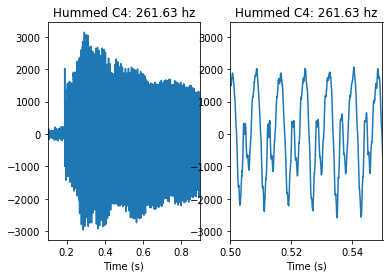

In [4]:
test_note = notes[0]
hum_note = hums[notes.index(test_note),:]
fs = hum_training.hums[test_note].fs

# Create array of time samples
t_array_len = hums[notes.index(test_note),:].shape[0]
t_array = np.arange(t_array_len)

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} hz'.format(test_note,freq_dict[test_note]))
plt.plot(t_array/fs, hum_note)

plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} hz'.format(test_note,freq_dict[test_note]))
plt.plot(t_array/fs, hum_note)

plt.show()


### Plot Frequency

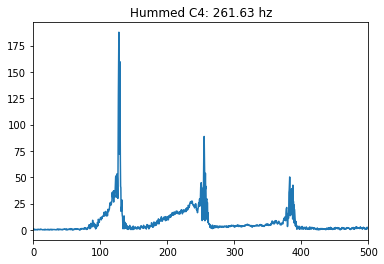

In [5]:
ftransform = np.fft.fft(hum_note)/len(hum_note)
ftransform = ftransform[range(int(len(hum_note)/2))]
tp_count = len(hum_note)
vals = np.arange(int(tp_count)/2)
t_period = tp_count/fs
freqs = vals/t_period

plt.plot(freqs,abs(ftransform))
plt.xlim((0,500))
plt.title('Hummed {}: {} hz'.format(test_note,freq_dict[test_note]))
plt.show()

## Create Training Set
### Synthesize larger dataset 
Add random shifts and noise to original recordings

In [6]:
# Initialize matrix where each row contains a noisy sample
X = np.empty((n_entries*n_class,hum_len))

# Add white noise to each element
for idx in range(n_class):
    for sample in range(n_entries):
        X[sample+n_entries*(idx),:] = add_noise(hums[idx,:])
  

### Plot example with added noise


Text(0.5, 1.0, 'Hummed C note with noise')

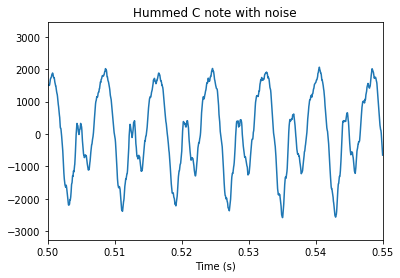

In [7]:
plt.plot(t_array/fs,X[0,:])
plt.show
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed C note with noise')

### Extract features

In [8]:
# Ideally this should be equal to 'notes'
feat_notes = ('C3', 'D3', 'E3', 'F3', 'G3', 'A3')
#feat_notes = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4')

X_feat = music_feat_ext(X,fs,freq_dict,feat_notes)

### Define Train/Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, random_state=1)

## Train Model
### Define Model

In [10]:
model = svm.SVC(gamma='scale')

In [11]:
### Fit Model

In [12]:
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Test Model

In [13]:
y_predict = model.predict(X_test)
print(f"Accuracy on test set: {100*accuracy_score(y_test, y_predict)}")

Accuracy on test set: 100.0


## Save Model

In [14]:
model_folder = r"..\model\trained_models"
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_name = 'model.sav'
pickle.dump(model, open(os.path.join(model_folder,model_name), 'wb')) 

## Test Model

In [15]:
from piano_notes import note_class
# ERROR above - from make_tone import music_dict

hum_wav_file = r"..\sound_files\Hum_C4.wav"
fs_in, wav_sig_in = wav.read(hum_wav_file)

hum_len = 130000
hums = np.empty((1,hum_len))
hums[0,:] = wav_sig_in[:hum_len,1]

X_feat = music_feat_ext(hums,fs_in,freq_dict,feat_notes)

predicted_notes = model.predict(X_feat)
for note in predicted_notes:
    print("Predicted note: "+note)

note_predict = note_class(note=predicted_notes[0])
note_predict.sound.play(1)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


ModuleNotFoundError: No module named 'make_tone'